# Poisson Kriging - Area to Area Kriging 
## Table of Contents:
1. Load areal and point data,
2. Load semivariogram (regularized),
3. Remove 10% of areal dataset,
4. Predict values at unknown locations,
5. Analyse Forecast Bias and Root Mean Squared Error of prediction.



## 1. Read and explore data

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from pyinterpolate import prepare_areal_shapefile
from pyinterpolate import get_points_within_area
from pyinterpolate import fit_semivariance
from pyinterpolate import ArealKriging

In [2]:
areal_data_file = './input_data/merged_data_and_shp_2180/covid_wrzesien_2180.shp'
#czemu sample_data w tutorialach nie są w folderze tutorials
point_data_file = './input_data/population_data/population_centroids_poland.shp'

areal_id_column_name = 'ID'
areal_val_column_name = '14.09'
points_val_column_name = 'TOT'


areal_data = prepare_areal_shapefile(areal_data_file,
                                     id_column_name=areal_id_column_name,
                                     value_column_name=areal_val_column_name)
point_data = get_points_within_area(areal_data_file, point_data_file, areal_id_col_name=areal_id_column_name,
                                   points_val_col_name=points_val_column_name)


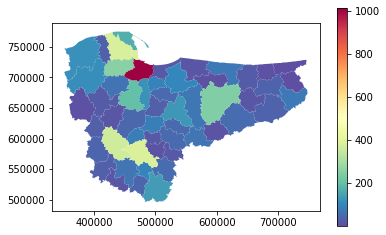

In [4]:
# Lets take a look into a map of areal counts

gdf = gpd.read_file(areal_data_file)
gdf.plot(column='14.09', cmap='Spectral_r', legend=True)

## 2. Load semivariogram model

In this step we load regularized semivariogram from the tutorial Semivariogram Regularization (Intermediate). You can always perform semivariogram regulariztion along with the Poisson Kriging but it is a very long process and it is more convenient to separate those two steps.

In [6]:
semivariogram = fit_semivariance.TheoreticalSemivariogram()  # Create TheoreticalSemivariogram object
semivariogram.import_model('./output_data/regularized_model.csv')  # Load regularized semivariogram


## 3. Prepare training and test data

We simply remove 10% of random ID's from areal dataset (the same for points) and create four arrays: two training arrays with areal and point geometry and values and two test arrays with the same categories of data.

In [7]:
# Remove 10% of rows (values) to test our model

def create_test_areal_set(areal_dataset, points_dataset, frac=0.1):
    """
    Function creates set with random areas for tests
    
    INPUT:
    :param areal_dataset: (numpy array) array with rows of areal records,
    :param points_dataset: (numpy array) array with rows of points records,
    :param frac: (float) number of elements in a test set
    
    OUTPUT:
    return: [training_set_areal(numpy array),
             test_set_areal (numpy array),
             training_set_points (numpy array),
             test_set_points (numpy array)]
    """
    
    all_ids = areal_dataset[:, 0]
    training_set_size = int(len(all_ids) * (1 - frac))
    training_ids = np.random.choice(all_ids,
                                    size=training_set_size,
                                    replace=False)
    training_areas = np.array(
            [a for a in areal_dataset if a[0] in training_ids])
    test_areas = np.array(
            [a for a in areal_dataset if a[0] not in training_ids])
    training_points = np.array(
            [pt for pt in points_dataset if pt[0] in training_ids])
    test_points = np.array(
            [pt for pt in points_dataset if pt[0] not in training_ids])
    

    output = [training_areas, test_areas, training_points, test_points]
    return output

ar_train, ar_test, pt_train, pt_test = create_test_areal_set(areal_data, point_data)
# ale magia czy takie przypisanie ma jakieś ograniczenia

## 4. Predict values at unknown locations and calculate forecast bias and root mean squared error
Do you know scikit-learn's fit-predict-transform estimation procedure?
!!!Nie, nie znam

With Kriging it is more complicated because we are fitting semivariogram model to data and we pass this fitted model into kriging estimator. That's why package with TheoreticalSemivariogram() class is named fit_semivariance. You may start work with predictions with fitted semivariogram model. Area-to-Area Poisson Kriging takes three arguments during initialization:

=> semivariogram model (fitted semivariogram model), => known areas (training set), => known points (training set).

After initilization you may perform prediction. This process requires you to control two hyperparameters:

=> number of observations (the most important parameter - how many neighbors are affecting your area of analysis), => minimum search radius (minimum search radius for analysis from your area of interest, if there are less areas than number of observations then the new, next closest neighbors are included in the analysis),

!!! nie jestem pewien czy rozumiem, chyba już  rozumiem, bierzemy wszystkie próbki z koła o rozmiarze minimum_search_radius, jeśli jest ich mniej niż number_of_observations to wtedy dobierasz najbliższe.

!!! czy wybierasz number_of_observations z minimum_search_radius, jeśli nie ma wystarczająco to w tedy dobierasz, aż będziesz miał number_of_observations



Why radius parameter is less important than number of observations? It is a tradeoff between mathemtical accuracy and reality. Usually your areas of interest have different shapes and sizes and with very large county and small search radius from the centroid you may not find any neighbour!

The main difference between Area-to-Area and Centroid Poisson Kriging is that for the former you pass only variable with smaller blocks which are representing fine scale process withing area with missing value. Centroid PK is "feed" with missing area geometry too.

Algorithm in the cell below iteratively picks one area from the test set and perform prediction. Then forecast bias which is difference between real and predicted value is calculated. Forecast Bias is useful to understand if our algorithm predictions are too low or too high (under- or overestimation). The next parameter is Root Mean Squared Error. This kind of measure tells us more about outliers and very large differences between predictions and real values. We will see it in the last part of tutorial.

Your work with Poisson Kriging (or Kriging) will be usually the same:
* prepare training and test data,
* use training data to prepare semivariogram model,
* test different hyperparameters with a test set to find optimal number of neighbors which are affecting your area of analysis,
* forecast into unknown areas OR perform data smoothing.


In [1]:
number_of_obs = 8
#!!! dlaczego 8, jeśli dobrze rozumiem to z dupy
#!!! nie powinno to zależeć od modelu? 
radius = 80000
# czy zazwyczaj dla powiatóœ w polsce mogę sobie używać 80k, bo siatka punktów to przecież 5k


kriging_model = ArealKriging(semivariogram_model=semivariogram,
    known_areas=ar_train,
    known_areas_points=pt_train,
    kriging_type='ata')

kriged_predictions = []

NameError: name 'ArealKriging' is not defined

In [9]:
# też dodać do tego procesu progress bar?
for unknown_area in ar_test:
    unknown_points = pt_test[pt_test[:, 0] == unknown_area[0]][0]

    # Predict
    try:
        #dkiedy dostanie ValueError
        predicted = kriging_model.predict(unknown_points,
                                          number_of_obs,
                                          radius)
        predicted_accidents = int(predicted[0])
        # działa tylko dla danych całkowitych, typu liczba zarażonych. Ale kringing nie musi działać tylko na całkowitych, prawda?
        fb = (unknown_area[-1] - predicted_accidents)
        rmse = np.sqrt((fb)**2)
        
        kriged_predictions.append([unknown_area[0], predicted_accidents, unknown_area[-1], fb, rmse])
    except ValueError:
        fb = np.nan
        rmse = np.nan
        kriged_predictions.append([unknown_area[0], np.nan, unknown_area[-1], fb, rmse])  # All NaN's

In [10]:
kriged_predictions = np.array(kriged_predictions)
pred_df = pd.DataFrame(data=kriged_predictions[:, 1:],
                       index=kriged_predictions[:, 0],
                       columns=['predicted', 'real', 'forecast bias', 'rmse'])  # Store results in DataFrame


## 5. Analyze Forecast Bias and Root Mean Squared Error of prediction

The last step is analysis of errors. We plot two histograms: of forecast bias and of root mean squared error then we calculate base statistics of a dataset.

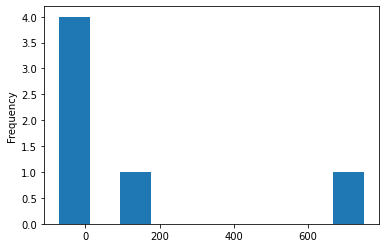

In [11]:
# Show histograms of errors

pred_df['forecast bias'].plot.hist(bins=10)
# słabo działa bo mało danych co nie?

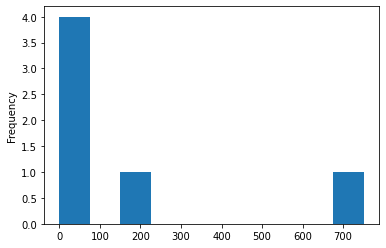

In [12]:
pred_df['rmse'].plot.hist(bins=10)


In [13]:
pred_df.describe()

,predicted,real,forecast bias,rmse
count,6.000000,6.000000,6.000000,6.000000
mean,97.166667,230.166667,133.000000,179.000000
std,84.233999,393.301623,315.527495,286.941109
min,29.000000,16.000000,-70.000000,0.000000
25%,51.000000,23.750000,-51.000000,25.250000
50%,78.000000,42.000000,5.500000,69.000000
75%,90.000000,198.250000,133.250000,148.000000
max,262.000000,1013.000000,751.000000,751.000000


**Clarification:**

1. **Forecast Bias** histogram shows tendency towards positive values; our model underestimates missing values.
2. **Root Mean Squared Error** opis w ogóle nie pasuje


histogram is skewed towards the 0 which is good and there are not so many outliers (75% of values are below 5.25). RMSE mean is 5 units (accidents) and it is less than the mean of real values. The same property can be seen for standard deviation. It may be assumed that our Kriging model decreases general variance of the areal dataset.

